# Extracting from free text with MedCAT

This tutorial serves as an introduction on how to use *ehrapy* together with [MedCAT](https://github.com/CogStack/MedCAT). *MedCat* is a tool to extract medical entities from free text and link it to biomedical ontologies. Biomedical entities could be anything biomedical; not only diagnoses or diseases but also symptoms, drugs or even peptides. 
It also tries to keep the context of an extracted entitiy (for example, whether a specific disease has been diagnosed or not). This is especially important for electronic health records data, as most of the time doctors notes are simply copied and pasted into the data and not preprocessed in any form. Consider the following example:

- The patient suffers from diabetes.

 vs.
 
- The patient does not suffer from diabetes.


In detail, ehrapy uses a pretrained and packages model from MedCat (https://medcat.readthedocs.io/en/latest/main.html#models). This model is limited in performance but good enough for this demonstration. A larger (trained) model is planned to be released somewhen in the (near) future by the MedCAT maintainers.

In [11]:
import ehrapy as ep
import pandas as pd
from medcat.cat import CAT

In [12]:
ep.settings.n_jobs = 2

Download the example data

In [30]:
!wget -nc https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv -P ./medcat_data/
!wget -nc https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip -P ./medcat_data/

File ‘./medcat_data/pt_notes.csv’ already there; not retrieving.

File ‘./medcat_data/medmen_wstatus_2021_oct.zip’ already there; not retrieving.



## Custom MedCAT object of ehrapy

To allow for seemless interoperability of ehrapy and MedCAT, we require a "superobject" that references the AnnData object while providing the MedCAT functionality. This object further stores MedCAT related features such as a *vocabulary*, a *concept database* and (later on in this tutorial) also the *annotated results*.

First, we read the example data into an AnnData object, encode the data and calculate neighbors for subsequent processing.
As a next step, we create the MedCAT object with a modelpack and set default TUI filters.
A full list of TUI’s can be found at: https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/Docs/SemanticTypes_2018AB.txt

In [17]:
adata = ep.io.read_csv("medcat_data/pt_notes.csv", columns_obs_only=["text"])
adata_encoded = ep.pp.encode(adata, autodetect=True)

2023-12-12 11:02:05,466 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `1088` x `8`.
2023-12-12 11:02:05,470 - root INFO - The original categorical values `['category', 'gender']` were added to uns.


Output()

2023-12-12 11:02:05,479 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.
2023-12-12 11:02:05,480 - root INFO - Updated the original layer after encoding.


2023-12-12 11:02:05,484 - root INFO - The original categorical values `['category', 'gender']` were added to obs.


In [18]:
# create the main ehrapy medcat object used for medical entitiy analysis using ehrapy and medcat
cat = CAT.load_model_pack("./medcat_data/medmen_wstatus_2021_oct.zip")

# only use diseases and behavioural disorders diagnoses in this example by filtering by TUI
tuis=["T047", "T048"]
cui_filters = set()
for type_id in tuis:
    cui_filters.update(cat.cdb.addl_info["type_id2cuis"][type_id])
cat.cdb.config.linking["filters"]["cuis"] = cui_filters


Using this model pack we can already extract entities from an example note.

In [19]:
text = "He was diagnosed with kidney failure"
doc = cat(text)
doc.ents

(kidney failure,)

In [20]:
# Example output of an extracted medcat entity; note that ehrapy will deal with this automatically and the here displayed manual extraction is not required.
# CUI: Concept Unique Identifier, which is just an unique identifier for each concept extracted
cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'type_ids': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {'Status': {'value': 'Affirmed',
     'confidence': 0.9999961853027344,
     'name': 'Status'}}}},
 'tokens': []}

## Extracting and visualizing all disease entities

To extract all disease entities from our example dataset we require a complete annotation of the dataset. This step is computationally expensive and may take some time.

In [21]:
ep.tl.annotate_text(adata_encoded, cat, text_column="text", n_proc=2)

The annotated results as extracted by MedCAT are transformed and stored into a Pandas DataFrame

In [22]:
adata_encoded.uns["medcat_annotations"].head()

,row_nr,pretty_name,cui,type_ids,types,meta_anns
0,0,Diabetes,C0011847,[T047],[Disease or Syndrome],Affirmed
1,0,Sepsis,C0243026,[T047],[Disease or Syndrome],Other
2,0,"Respiratory Distress Syndrome, Adult",C0035222,[T047],[Disease or Syndrome],Affirmed
3,0,Pulmonary Embolism,C0034065,[T047],[Disease or Syndrome],Other
4,0,Respiratory Failure,C1145670,[T047],[Disease or Syndrome],Affirmed


We can also get a proper overview for the top 10 most entities found in the data (affirmed diagnoses only).

In [24]:
ep.tl.get_medcat_annotation_overview(adata_encoded).head(10)

,pretty_name,type_ids,types,n_patient_visit,n_patient_visit_percent
cui,,,,,
C0000833,Abscess,T047,Disease or Syndrome,8,0.785083
C0001314,ACUTE DIS,T047,Disease or Syndrome,6,0.588813
C0001339,Acute pancreatic inflammation,T047,Disease or Syndrome,1,0.098135
C0001883,airway obstruction,T047,Disease or Syndrome,6,0.588813
C0001969,Alcoholic Intoxication,T048,Mental or Behavioral Dysfunction,5,0.490677
C0002395,Alzheimer's Disease,T047,Disease or Syndrome,38,3.729146
C0002871,Anemia,T047,Disease or Syndrome,54,5.299313
C0003123,Anorexia,T047,Disease or Syndrome,11,1.079490
C0003467,Anxiety,T048,Mental or Behavioral Dysfunction,54,5.299313


Alternatively, we can also get an overview of the top 10 negated diagnoses only.

Since our MedCAT is aware of both, the annotation results and the AnnData object, we can just pass it to any plotting functions of ehrapy, just we like we are used to with AnnData objects.
First, we calculate a UMAP embedding using the AnnData object and then we color by all patients that had detected annotations for e.g. Diabetes or Congestive heart failure.

In [25]:
ep.tl.add_medcat_annotation_to_obs(adata_encoded, name=["Diabetes", "Congestive heart failure"])

Typos when trying to move annotations to obs will raise a warning with suggestions for the annotation

In [26]:
ep.tl.add_medcat_annotation_to_obs(adata_encoded, name="Diubetes")

EntitiyNotFoundError: Did not find '['Diubetes']' in MedCAT's extracted entities. Do you mean Diabetes?

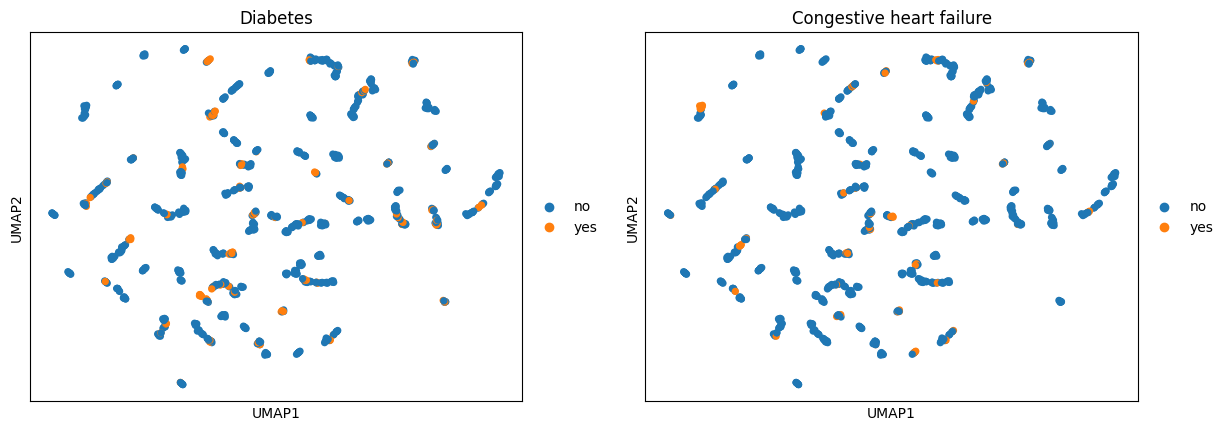

In [27]:
ep.pp.neighbors(adata_encoded)
ep.tl.umap(adata_encoded)
ep.pl.umap(adata_encoded, color=["Diabetes", "Congestive heart failure"])

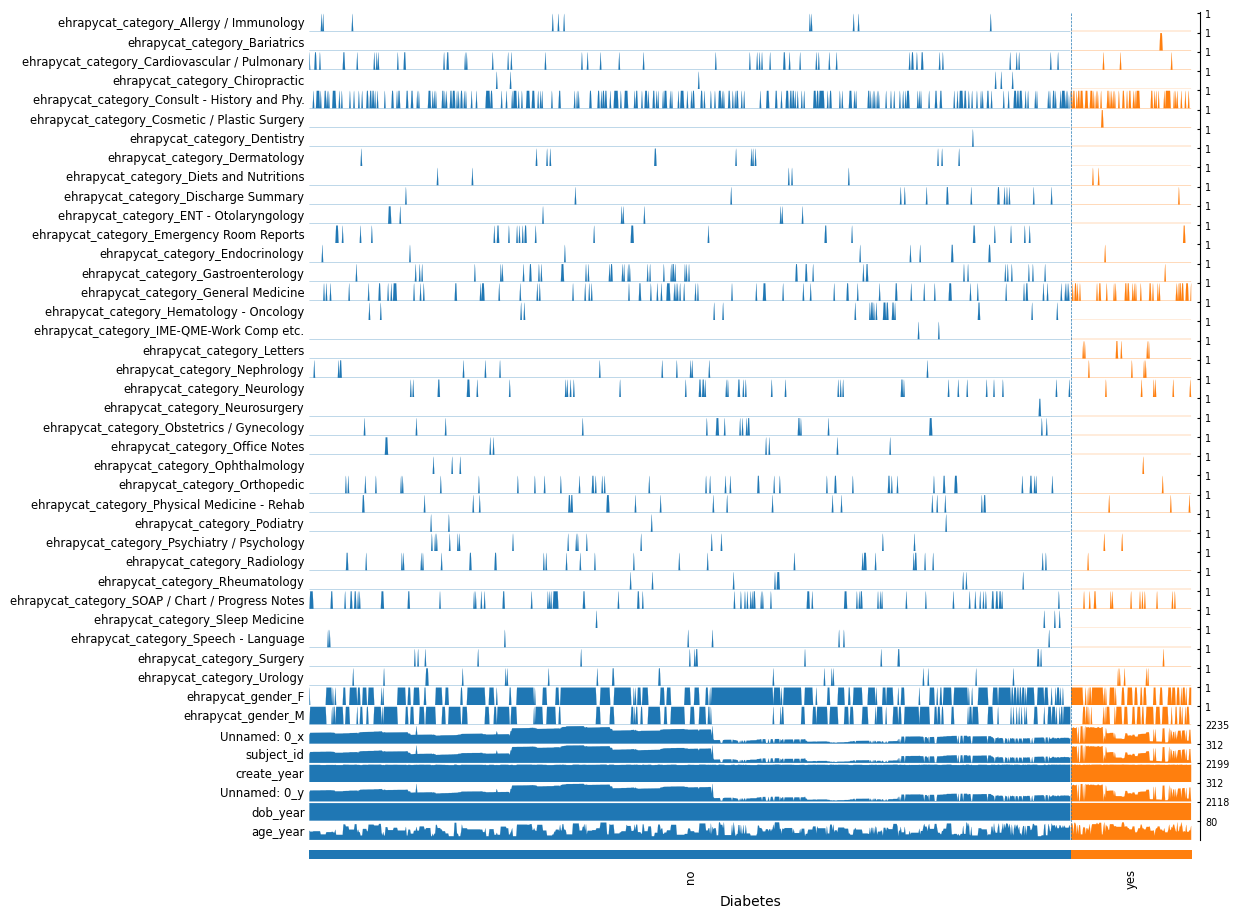

In [46]:
ep.pl.tracksplot(adata_encoded, list(adata_encoded.var_names), groupby="Diabetes")